In [52]:
import pylab
import numpy
from random import random, randint
from copy import deepcopy
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

In [88]:
#library of elements; there are three types: value, function (+,-,*,/) or graph
lib = [{"type":"value","symbol":"v"},{"type":"function","function":lambda a:a[0]+a[1],"symbol":"+"},{"type":"function","function":lambda a:a[0]-a[1],"symbol":"-"},{"type":"function","function":lambda a:a[0]*a[1],"symbol":"*"},{"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
#add a graph for each operator
for n in range(1,4):
    g = {"type":"graph","graph":[{"lib_id":0,"input":[],"arg_index":0},{"lib_id":0,"input":[],"arg_index":1},{"lib_id":n,"input":[0,1]}]}
    lib.append(g)

In [89]:
#function that takes in a graph and a list of input numbers and evaluates its result
def eval(graph,values,index=-1):
  #this case corresponds to 
  if index == -1:
    index = find_output_node(graph)
  node = graph[index]
  lib_entry = lib[node["lib_id"]]
  node_type = lib_entry["type"]
  if node_type == "value":
    return values[node["arg_index"]]
  else:
    args = []
    for argument in node["input"]:
      arg = eval(graph,values,argument)
      args.append(arg)
    if node_type == "function":
        return lib_entry["function"](args)
    elif node_type == "graph":
        return eval(lib_entry["graph"](args),args)

#returns the position of the output node within the graph
def find_output_node(graph):
    referenced = []
    for node in graph:
      referenced += node["input"]
    for n, node in enumerate(graph):
      if n not in referenced:
        return n

#returns the number of arguments of a graph
def number_of_arguments(graph):
    n_arg = 0
    for n, node in enumerate(graph):
        lib_entry = lib[node["lib_id"]]
        node_type = lib_entry["type"]
        if node_type == "value":
            n_arg += 1
    return n_arg

#returns a list with elements of the type [position of the argument in the graph,argument index in the argument vector]
def input_info(graph):
    args = []
    for n, node in enumerate(graph):
        lib_entry = lib[node["lib_id"]]
        node_type = lib_entry["type"]
        if node_type == "value":
            args.append([n,node["arg_index"]])
    n_args = len(args)
    arguments = [0 for i in range(n_args)]
    for arg in args:
        arguments[arg[1]] = arg[0]
    return arguments

#function that combines two graphs by using the output node of the second graph as one of the inputs of the first
def insert_at(donor_graph,recipient_graph,site=-1):
    recipient_args = input_info(recipient_graph)
    donor_args = input_info(donor_graph)
    if site == -1:
        site = randint(0,len(recipient_args)-1)
    site_index = recipient_args[site]
    site_arg_index = recipient_graph[site_index]["arg_index"]
    donor_output = find_output_node(donor_graph)
    new_graph = [deepcopy(node) for node in recipient_graph]
    new_graph.pop(site_index)
    for n, node in enumerate(new_graph):
        lib_entry = lib[node["lib_id"]]
        node_type = lib_entry["type"]
        if node_type == "function" or node_type == "graph":
            node_input = [ni for ni in node["input"]]
            for s, subnode in enumerate(node_input):
                if subnode > site_index:
                    node_input[s] = subnode - 1
                elif subnode == site_index:
                    node_input[s] = donor_output + len(new_graph)
            node["input"] = node_input
        elif node_type == "value":
            node["arg_index"] -= (1 if node["arg_index"] > site_arg_index else 0)
    processed_donor = [deepcopy(node) for node in donor_graph]
    for n, node in enumerate(processed_donor):
        lib_entry = lib[node["lib_id"]]
        node_type = lib_entry["type"]
        if node_type == "function" or node_type == "graph":
            node_input = [ni for ni in node["input"]]
            node["input"] = [ni + len(new_graph) for ni in node_input]
        elif node_type == "value":
            node["arg_index"] += len(recipient_args) - 1
    return new_graph+processed_donor

#this function draws the graph
def draw(graph):
    G = G=nx.MultiDiGraph()
    for n, node in enumerate(graph):
        G.add_node(n,attr_dict=node)
    for n1, node in enumerate(graph):
        for i, n2 in enumerate(node["input"]):
            G.add_edge(n2, n1, attr_dict={"arg":i})
    labels = {}
    for n, node in enumerate(G.nodes(data=True)):
        labels[n] = lib[node[1]["lib_id"]]["symbol"]
    plt.close()
    nx.draw(G,labels = labels,with_labels = True,pos=nx.spring_layout(G))
    plt.show()

#given a set of parameters 
def error(graph,parameters,variable_position,data):
    X = data["x"]
    Y = data["y"]
    e = 0
    arg = deepcopy(parameters)
    for x,y in zip(X,Y):
        arg[variable_position] = x
        e += (y-eval(graph,arg))**2
    return e

#optimizes a given graph on a set of data points x and y
def optimize(graph,data):
    n_args = number_of_arguments(graph)
    v = randint(0,n_args-1)
    
    #for a in range(n_args):
        

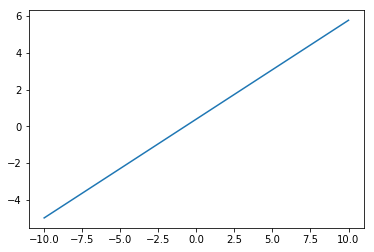

In [46]:
pylab.close()
g3 = insert_at(g2,g1)
x = numpy.linspace(-10,10,100)
values = [random() for n in range(number_of_arguments(g3))]
value_matrix = [[(xe if v == 0 else value) for v, value in enumerate(values)] for xe in x]
y = numpy.array([ eval(g3,value_matrix[i]) for i in range(len(value_matrix)) ])
pylab.plot(x,y)
pylab.show()

/Users/david/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/david/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/david/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/david/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is de

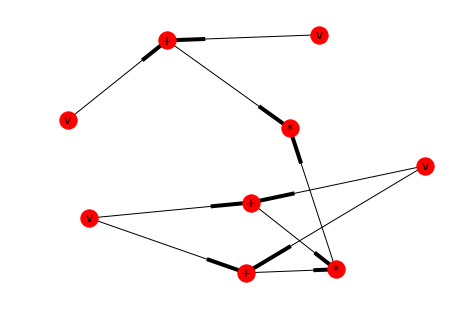

In [48]:
draw(g3)

In [96]:
x = numpy.linspace(-10,10,100)
y = 2*x
error(lib[7]["graph"],[2.,2],1,{"x":x,"y":y})

0.0